# Brain Tumor Semantic Segmentation Using ResUNet

**Objective**: Build a ResUnet architecture to segment a brain tumor from a brain MRI image

**Opt-in**:
* Segmentation/Detection Application

**Introduction**:

Lower-grade gliomas (LGG) are a group of WHO grade II and grade III tumors. These groups are infiltrative and tend to recur after surgical resection and expand to a higer-grade lesion. The challenge here is to accurately predict patient outcomes based on histopathological data for these tumors. 

**Built with**:
`Python, PyTorch, Albumentations, Matplotlib, cv2, sklearn`

**Methods**:

To tackle this challenge, I implemented a deep learning model to facilitate the automatic tumor segmentation of this dataset. Specifically, I combined a UNet architecture with residual blocks from a pre-trained ResNet50. Then, I augmented the training dataset and trained this ResUNet model on it.
+ Data Preparation

+ Data Exploration

+ Data Splitting

+ Data Generator and Augmentation

+ Model: UNet ResNeXt50

+ Custom quality metric and loss function

+ Model training and validation

+ Model Evaluation

+ Visualization of the test prediction

**Results**

My ResUNet model achieved a Mean IoU score of 90% after training for 50 epochs.

**Conclusions**

Even though this is not a fine-tuned model, its performance is quite surprising. Thus, choosing an appropriate model is a crucial step in any machine learning/ deep learning pipeline.  
I will embed this ResUNet architecture into a multimodality model to further expand this project to predict the tumor grade and a patient's overall survival rate. Then, I will deploy this model to provide a more interactive environment. 

## Import Libraries

In [ ]:
# Data preprocessing
import sys
import os
import numpy as np
import pandas as pd
import copy
import glob
import random
import time


# Data visualization
from skimage import io
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid


plt.style.use("default")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  app.launch_new_instance()


In [ ]:
# Data Loader and Model Building
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Data Augmentation
import albumentations as A
from albumentations.pytorch import ToTensor

# Data splitting
from sklearn.model_selection import train_test_split

## Data Preparation

### Download Dataset
We use [the Brain MRI segmentation dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation) from Kaggle

In [ ]:
# install the Kaggle library
! pip install -q kaggle
# import the colab IO library
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nghihuynh","key":"1092b8eb7988019b710db42156498b0e"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list #show a list of some available datasets

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              234KB  2021-08-07 09:10:20          10338  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           6319  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           2368  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-07-03 18:37:20           2587  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
# it is to have a specific version of the kaggle module to access some kaggle datasets
# this will hopefully be fixed in future updates
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.6 MB 8.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     |████████████████████████████████| 58 kB 4.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=d68702c48f83b9c37c94cf4ee99b625aba25c7826d486740cdaa15dd91116373
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle


In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 98% 698M/714M [00:05<00:00, 161MB/s]
100% 714M/714M [00:05<00:00, 138MB/s]


In [ ]:
print("----- unzipping files -----")
!unzip -q /content/lgg-mri-segmentation.zip 

----- unzipping files -----


In [ ]:
# Path to all data
DATA_PATH = "/content/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 84 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

### Creating a DataFrame

In [ ]:
data = pd.read_csv(DATA_PATH+"data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: /content/lgg-mri-segmentation/kaggle_3m/data.csv
This is not a dir: /content/lgg-mri-segmentation/kaggle_3m/README.md


,dirname,path
0,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
1,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
2,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
3,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...
4,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...


In [ ]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]
# Data sorting
imgs = sorted(df_imgs.path.values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks.path.values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_40.tif 
Path to the Mask: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_40_mask.tif


In [ ]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                   "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_F...,0
1,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
3,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
4,TCGA_FG_5964_20010511,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
...,...,...,...,...
3924,TCGA_HT_7856_19950831,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
3925,TCGA_HT_7856_19950831,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
3926,TCGA_HT_7856_19950831,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
3927,TCGA_HT_7856_19950831,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0


## Data Exploration

### Clinical data distribution

In [ ]:
data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


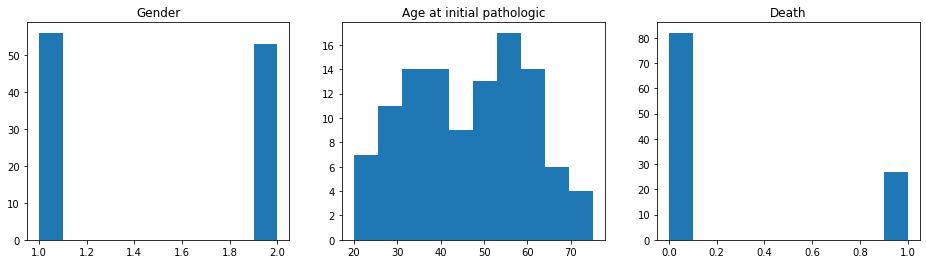

In [ ]:
# The statistics of data
fig, axs = plt.subplots(1,3, figsize=(16,4))
axs[0].hist(data.gender)
axs[1].hist(data.age_at_initial_pathologic)
axs[2].hist(data.death01)

axs[0].set_title("Gender")
axs[1].set_title("Age at initial pathologic")
axs[2].set_title("Death")

fig.savefig('clinical_stats.png',dpi=100)

### MRI Data Distribution

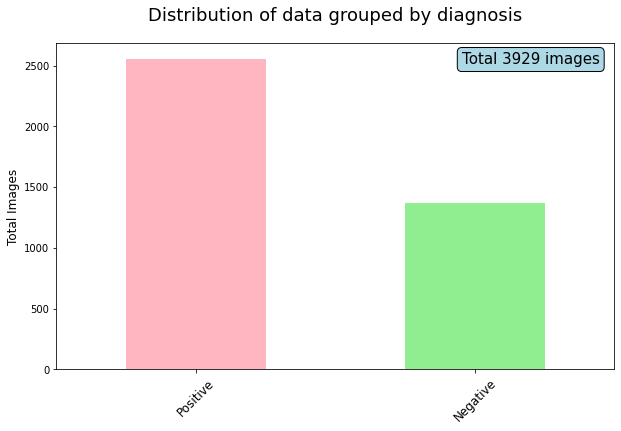

In [ ]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                      color=["lightpink", "lightgreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

### Visualize original brain images and its masks
Define a function that takes a dataframe and visualize the brain MRI images, its corresponding masks, and the overlay of masks on its brain images

In [ ]:
def display_brain_image(df,num_plots):
    count = 0
    i = 0
    fig, axs = plt.subplots(num_plots,3, figsize=(20,30))
    for mask in df['diagnosis']:
        if (mask==1): # only visualize brain images with masks
            # brain image
            img = io.imread(df.image_path[i])
            axs[count][0].imshow(img)
            axs[count][0].set_title("Brain MRI")
            
            # mask image
            mask = io.imread(df.mask_path[i])
            axs[count][1].imshow(mask, cmap='gray')
            axs[count][1].set_title("Mask")
            
            # overlay mask image on brain image
            img[mask==255] = (0,255,255) # change pixel color at the position of a mask
            axs[count][2].imshow(img)
            axs[count][2].set_title("MRI with Mask")
            
            count += 1
        i += 1
        if (count==num_plots):
            break
    fig.tight_layout()
    fig.savefig('orignal.png')

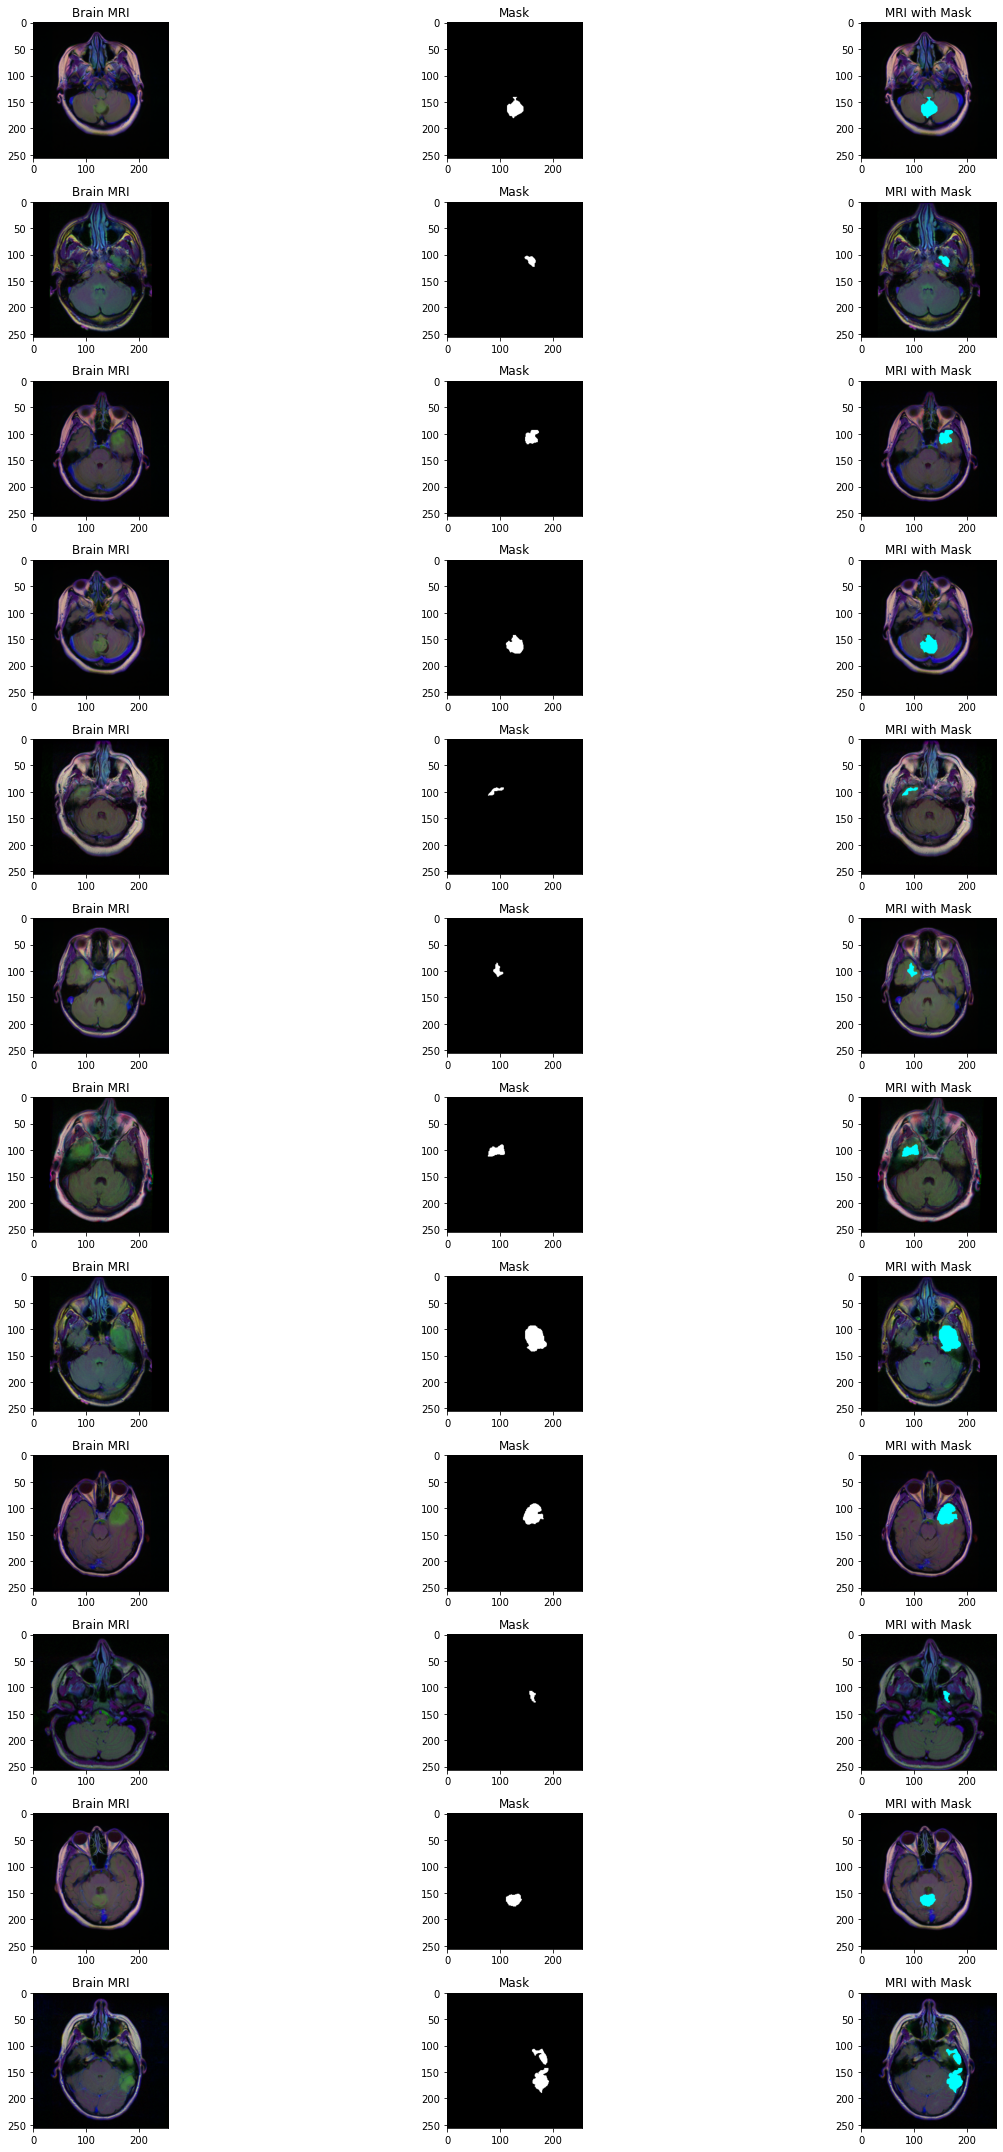

In [ ]:
display_brain_image(df,12)

## Data Splitting

In [ ]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


## Data Generator and Data Augmentation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device {device}')

Using device cuda


### PyTorch dataset class

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)


        if self.transforms is not None:
          augmented = self.transforms(image=image, 
                                      mask=mask)
          image = augmented['image']
          mask  = augmented['mask']   
        
        return image, mask
     

### Create augmentation pipelines

In [ ]:
PATCH_SIZE = 128

train_transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    A.CLAHE(clip_limit=3.0,p=0.5),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    ToTensor(),
])


val_transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    A.Normalize(p=1.0),
    ToTensor(),
])



In [ ]:
# DataLoader for train set
train_dataset = BrainTumorDataset(df=train_df, transforms=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

# DataLoader for val set
val_dataset = BrainTumorDataset(df=val_df, transforms=val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

# DataLoader for test set
test_dataset = BrainTumorDataset(df=test_df, transforms=val_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Visualize different augmentations

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transforms = A.Compose([t for t in dataset.transforms if not isinstance(t, (A.Normalize,ToTensor))])
    fig, axs = plt.subplots(nrows=samples, ncols=3, figsize=(10,24))
    for i in range(samples):
        image, mask = dataset[idx]
        
        axs[i][0].imshow(image)
        axs[i][0].set_title("Augmented image")
        
        axs[i][1].imshow(mask,cmap='gray')
        axs[i][1].set_title("Augmented mask")
        
        image[mask==255] = (0,255,255)
        axs[i][2].imshow(image)
        axs[i][2].set_title("Overlay augmented image and mask")
    plt.tight_layout()
    plt.savefig('augmented_visualization.png',dpi=100)
    plt.show()


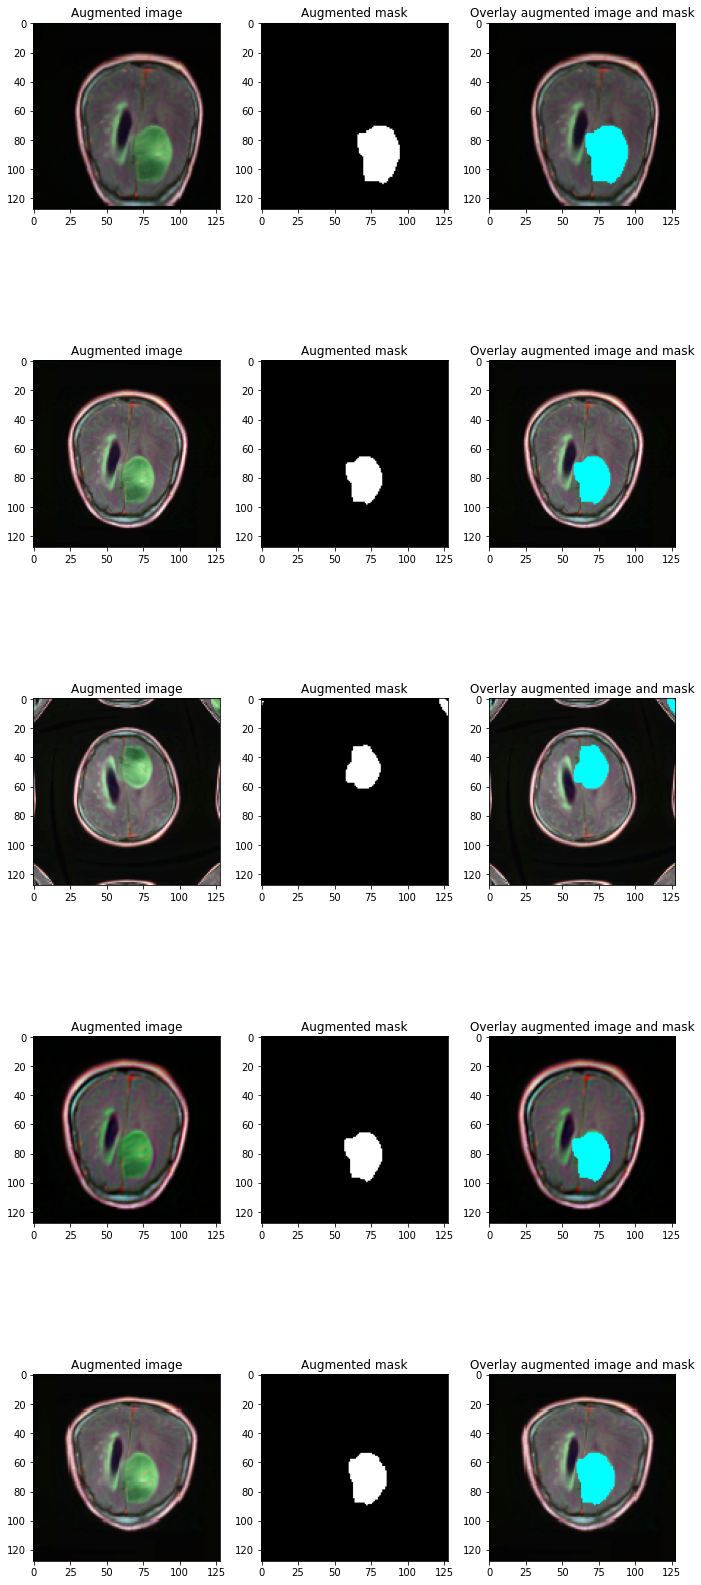

In [ ]:
random.seed(42)
visualize_augmentations(train_dataset, idx=4)

## Model: Unet with ResNeXt50 backbone.

In [ ]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [ ]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out

In [ ]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth



torch.Size([1, 1, 256, 256])


## Custom quality metric and loss function

### Define quality metric

In [ ]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

0.9473684210526316

### Define loss function

In [ ]:
def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

## Model training and validation

In [ ]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
                
        if lr_scheduler:
            
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()

        torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history


def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss


    return valloss / i_step

In [ ]:
# Optimizers
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

In [ ]:
%%time
num_ep = 50                                                                                                

# Train ResNeXt50
rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, False, num_ep)

ResNeXt50


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0]
Mean loss on train: 0.2747505672019103 
Mean DICE on train: 0.763255777476325 
Mean DICE on validation: 0.8162746121426974
Epoch [1]
Mean loss on train: 0.26408607352139624 
Mean DICE on train: 0.7701706154892001 
Mean DICE on validation: 0.8839328634363194
Epoch [2]
Mean loss on train: 0.28863949938837824 
Mean DICE on train: 0.7525894749480201 
Mean DICE on validation: 0.8274388746727678
Epoch [3]
Mean loss on train: 0.2421435336100644 
Mean DICE on train: 0.7893449930080636 
Mean DICE on validation: 0.8249251234127603
Epoch [4]
Mean loss on train: 0.27520682225967275 
Mean DICE on train: 0.7599521632120211 
Mean DICE on validation: 0.8599854017981978
Epoch [5]
Mean loss on train: 0.26191546613800115 
Mean DICE on train: 0.7721748068453003 
Mean DICE on validation: 0.8137690797439
Epoch [6]
Mean loss on train: 0.2651078261049657 
Mean DICE on train: 0.7712171704513906 
Mean DICE on validation: 0.8067270522224169
Epoch [7]
Mean loss on train: 0.26494427385001346 
Mean DICE o

## Model Evaluation

In [ ]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train dice', lw=3, c="blue")
    plt.plot(x, val_history, label='validation dice', lw=3, c="orange")

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    fn = str(int(time.time())) + ".png"
    plt.savefig(fn,dpi=100)
    plt.show()
    

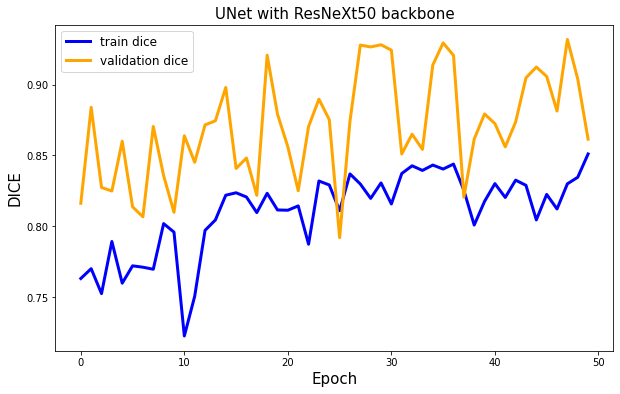

In [ ]:
plot_model_history("UNet with ResNeXt50 backbone", rx50_th, rx50_vh, num_ep)

## Visualization of the Test Prediction

### Test IoU

In [ ]:
test_iou = compute_iou(rx50, test_dataloader)
print(f"""ResNext50\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ResNext50
Mean IoU of the test images - 90.0%


### Predictive overlapping on test images

In [ ]:
test_samples = test_df[test_df["diagnosis"] == 1].sample(105).values


def batch_preds_overlap(model, samples):
    """
    Computes prediction on the dataset
    
    Returns: list with images overlapping with predictions
    
    """
    prediction_overlap = []
    #model.eval():
    for test_sample in samples:

         # sample
        image = cv2.resize(cv2.imread(test_sample[1]),(128, 128))
        image =  image / 255.

        # gt
        ground_truth = cv2.resize(cv2.imread(test_sample[2], 0), (128, 128)).astype("uint8")

        # pred
        prediction = torch.tensor(image).unsqueeze(0).permute(0,3,1,2)
        prediction = model(prediction.to(device).float())
        prediction = prediction.detach().cpu().numpy()[0,0,:,:]

        prediction[np.nonzero(prediction < 0.3)] = 0.0
        prediction[np.nonzero(prediction >= 0.3)] = 255.#1.0
        prediction = prediction.astype("uint8")

        # overlap 
        original_img = cv2.resize(cv2.imread(test_sample[1]),(128, 128))

        _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
        _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
        contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        overlap_img = cv2.drawContours(original_img, contours_gt, 0, (0, 255, 0), 1)
        overlap_img = cv2.drawContours(overlap_img, contours_p, 0, (255,36,0), 1)#255,0,0
        prediction_overlap.append(overlap_img)

    return prediction_overlap
    
    
#prediction_overlap_u = batch_preds_overlap(unet, test_samples)
#prediction_overlap_f = batch_preds_overlap(fpn, test_samples)
prediction_overlap_r = batch_preds_overlap(rx50, test_samples)

In [ ]:
# rx plates
pred_overlap_5x1_r = []
pred_overlap_5x3_r = []

for i in range(5, 105+5, 5):
    pred_overlap_5x1_r.append(np.hstack(np.array(prediction_overlap_r[i-5:i])))

for i in range(3, 21+3, 3):
    pred_overlap_5x3_r.append(np.vstack(pred_overlap_5x1_r[i-3:i]))

In [ ]:
# PLOT

def plot_plate_overlap(batch_preds, title, num):
    plt.figure(figsize=(15, 15))
    plt.imshow(batch_preds)
    plt.axis("off")

    plt.figtext(0.76,0.75,"Green - Ground Truth", va="center", ha="center", size=20,color="lime");
    plt.figtext(0.26,0.75,"Red - Prediction", va="center", ha="center", size=20, color="#ff0d00");
    plt.suptitle(title, y=.80, fontsize=20, weight="bold", color="#00FFDE");

    fn = "_".join((title+str(num)).lower().split()) + ".png"
    plt.savefig(fn, bbox_inches='tight', pad_inches=0.2, transparent=False, facecolor='black')
    plt.close()

    

title1 = "Predictions of Vanilla UNet"
title2 = "Predictions of FPN"
title3 = "Predictions of UNet with ResNeXt50 backbone"

for num, batch in enumerate(pred_overlap_5x3_r):
    plot_plate_overlap(batch,title3, num)
    

In [ ]:
from PIL import Image

def make_gif(title):
    base_name = "_".join(title.lower().split())

    base_len = len(base_name) 
    end_len = len(".png")
    fp_in = f"{base_name}*.png"
    fp_out = f"{base_name}.gif"

    img, *imgs = [Image.open(f) 
                  for f in sorted(glob.glob(fp_in), 
                                  key=lambda x : int(x[base_len:-end_len]))]

    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1000, loop=0)
    
    return fp_out

fn3 = make_gif(title3)

In [ ]:
from IPython.display import Image as Image_display

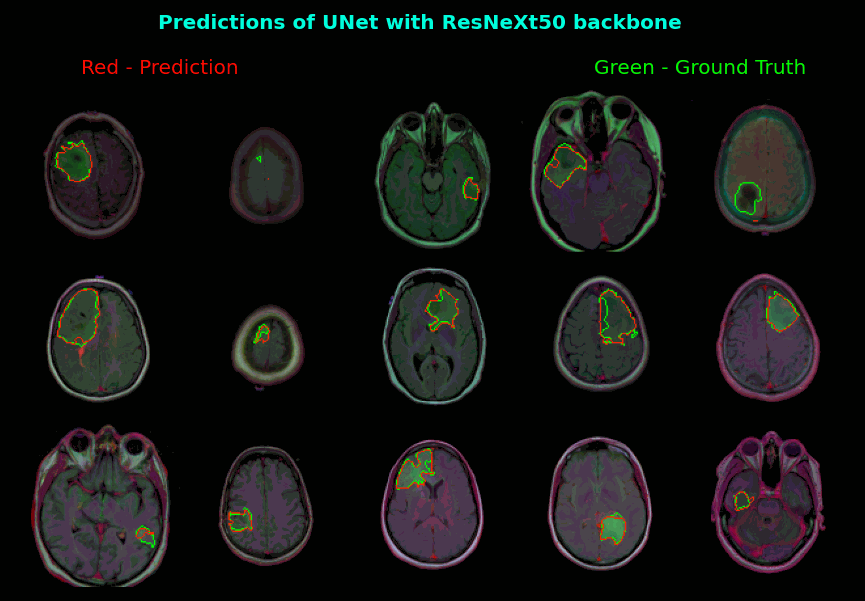

In [ ]:
with open(fn3,'rb') as f:
    display(Image_display(data=f.read(), format='png'))

## References:

* Model: [Model backbone](https://www.kaggle.com/bonhart/brain-mri-data-visualization-unet-fpn)
* Augmentations: [data augmentation](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/)
* Quality metrics: [metrics](https://www.semanticscholar.org/paper/Comparison-of-Jaccard%2C-Dice%2C-Cosine-Similarity-To-Thada-Jaglan/8575e8beef47bd2880c92f54a749f933db983e56)
* Loss function: [loss_fn](https://medium.com/kaggle-blog/carvana-image-masking-challenge-1st-place-winners-interview-78fcc5c887a8)